# Unscented Kalman Filter 

The Kalman filter predicts the current state based on the previous state，weighting the predicted state quantity with the measured quantity of the current moment. Only the the weighted result is considered to be the actual current state quantity which can be used to the next iteration. 
The kalman filter is specifically for linear system, and more pratically we can use unscented kalman filter to obtain the more accurate value of the state. The unscented kalman filter also contains the 'prediction' and 'update' process, but with the additional step of generating sigma points. The basic idea is to approximate the random distribution of a non-linear model by sampling from a known distribution.

In [1]:
from IPython.display import Latex

In [2]:
import numpy as np
import scipy
from numpy.random import randn
import numpy as np
from scipy.linalg import sqrtm
import math
import matplotlib.pyplot as plt   

Now we use a simple example to show the performance of the unscented kalman filter. It is no need to ust unsented kalman filter in this example because it is a linear example. But it is easy to read. 

In [3]:
# f(x)motion model

def motion_model(x,dt):
    """ 
    with constant velocity
    """
    F = np.array([[1, dt, 0,  0],
                  [0,  1, 0,  0],
                  [0,  0, 1, dt],
                  [0,  0, 0,  1]])
    return F @ x  

# h(x) observation model


def measurement(xTrue):
    #make a reference curve
    dt=1
    xTrue = motion_model(xTrue,dt)
    Add_Noise = np.diag([0.3, 0.3]) ** 2 
    z= observation_model(xTrue) + Add_Noise
    return xTrue, z  


def observation_model(x):
    ''' 
    the measurements are [x_pos, y_pos]
    '''
    H = np.array([
        [1, 0, 0, 0],
        [0, 0, 1, 0]
    ])

    z = H @ x

    return z


Now we propagate the variable $\textbf{x}$ through a nonlinear function $\textbf{y}$=$g(\textbf{x})$. Assume $\textbf{x}$ has mean $\mu$ and convariance $\Sigma$. To calculate the statistic of $\textbf{y}$, we form a matrix $\boldsymbol{\chi}$.
Some parameters which we can manually set up:$\alpha$, $\beta$. 
When the noise is gaussian distribution,we chose $\alpha=0.01$ and $\beta=2$.
$\kappa$ influence how far the sigma points are away from the mean.
The mean and covariance of the sigma points are computed as:

$$\begin{aligned}
\mu &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal{Y}}_i \\
\Sigma &= \sum_{i=0}^{2n} w^c_i{(\boldsymbol{\mathcal{Y}}_i-\mu)(\boldsymbol{\mathcal{Y}}_i-\mu)^\mathsf{T}}
\end{aligned}
$$

In [4]:
def setup_sgmpoints(n,alpha,beta,kappa):
    '''
    n : dimension of state vector
    alpha,beta,kappa : manually set up patamaters
    wm : weight matrix for calculating mean
    wc : weight matrix for calculating variance
    U : a parameter for computation convenience 
    '''
    lamb=alpha**2*(n+kappa)-n
    wm=[lamb/(n+lamb)]
    wc=[(lamb/(lamb+n))+(1-alpha**2+beta)]
    for i in range(2*n):
        wm.append(1/(2*(n*lamb)))
        wc.append(1/(2*(n*lamb)))
    U=math.sqrt(n+lamb)
    U=np.array([U])
    wm=np.array([wm])
    wc=np.array([wc])
    return wm,wc,U


alpha=.1
beta=2
kappa=-1
n=4
wm,wc,U=setup_sgmpoints(n,alpha,beta,kappa)
print(wm,wc,U)

[[-1.32333333e+02 -3.14861461e-02 -3.14861461e-02 -3.14861461e-02
  -3.14861461e-02 -3.14861461e-02 -3.14861461e-02 -3.14861461e-02
  -3.14861461e-02]] [[-1.29343333e+02 -3.14861461e-02 -3.14861461e-02 -3.14861461e-02
  -3.14861461e-02 -3.14861461e-02 -3.14861461e-02 -3.14861461e-02
  -3.14861461e-02]] [0.17320508]


In [5]:
#generazation of sigma ponits
# xEst/PEst is updated for each iteration

def generate_sigma_points(xEst, PEst, U):
    '''
    xEst:mean of initial data
    PEst:variance of initial data 
    U:U=sqrt(n+lamb)
    
    '''
    sigma = xEst
    Psqrt = scipy.linalg.sqrtm(PEst)
    #n = len(xEst[:, 0])
    n = len(xEst)
    for i in range(n):
        sigma = np.hstack((sigma, xEst + U * Psqrt[:, i:i + 1]))
    
    for i in range(n):
        sigma = np.hstack((sigma, xEst - U * Psqrt[:, i:i + 1]))
    return sigma


xEst = np.zeros((4, 1))
PEst=np.eye(4)
sigma = generate_sigma_points(xEst, PEst, U)
print(sigma)

[[ 0.          0.17320508  0.          0.          0.         -0.17320508
   0.          0.          0.        ]
 [ 0.          0.          0.17320508  0.          0.          0.
  -0.17320508  0.          0.        ]
 [ 0.          0.          0.          0.17320508  0.          0.
   0.         -0.17320508  0.        ]
 [ 0.          0.          0.          0.          0.17320508  0.
   0.          0.         -0.17320508]]


In [25]:
#initial state 
xEst_int = np.array([0,0,0,0])
xEst=np.reshape(xEst_int,[4,1])

#set up the parameters of sigma points
n=4
alpha=.1
beta=2
kappa=-1

sigmas = setup_sgmpoints(n,alpha,beta,kappa)
# Observation x,y position covariance
R = np.diag([0.3, 0.3]) ** 2  
print('measurement noise matrix R is:',R)

# process noise matrix

Q=np.zeros(shape=(4,4))
Q[0:2, 0:2] = np.random.normal(0, 0.02, size=(2, 2))
Q[2:4, 2:4] = np.random.normal(0, 0.02, size=(2, 2))
print('process noise matrix Q is:',Q)

def predict_sigma_motion(sigma):
    """
        Sigma Points prediction with motion model
    """
    for i in range(sigma.shape[1]):
        sigma[:, i:i + 1] = motion_model(sigma[:, i:i + 1],dt)

    return sigma

def predict_sigma_observation(sigma):
    """
        Sigma Points prediction with observation model
    """
    for i in range(sigma.shape[1]):
        sigma[0:2, i] = observation_model(sigma[:, i])

    sigma = sigma[0:2, :]

    return sigma



def calc_sigma_covariance(x, sigma, wc, Pi):
    d = sigma - x[0:sigma.shape[0]]
    P = Pi
    for i in range(sigma.shape[1]):
        P = P + wc[0, i] * d[:, i:i + 1] @ d[:, i:i + 1].T
    return P


def calc_pxz(sigma, x, z_sigma, zb, wc):
    '''
    
    '''
    nSigma = sigma.shape[1]
    dx = sigma - x
    dz = z_sigma - zb[0:2]
    P = np.zeros((dx.shape[0], dz.shape[0]))

    for i in range(nSigma):
        P = P + wc[0, i] * dx[:, i:i + 1] @ dz[:, i:i + 1].T

    return P



measurement noise matrix R is: [[0.09 0.  ]
 [0.   0.09]]
process noise matrix Q is: [[-0.04138707 -0.03105066  0.          0.        ]
 [ 0.03375027  0.01478474  0.          0.        ]
 [ 0.          0.          0.01440105 -0.02184554]
 [ 0.          0.         -0.01974958 -0.00145818]]


In [26]:
def ukf_estimation(xEst, PEst, z, wm, wc, gamma):
    '''
    z: observation with noise 
    wm, wc, gamma: constant parameters
    '''
    #  Predict process
    # generate sigma points
    
    sigma = generate_sigma_points(xEst, PEst, gamma)
    
    #prediction of mean of input 
    
    #xPred = (wm @ sigma.T).T
    xPred = (wm @ sigma.T).T
    
    # estimate of covariance 
    PPred = calc_sigma_covariance(xPred, sigma, wc, Q)

    #  Update 
    #  generate new sigma points after prediction 
    
    sigma = generate_sigma_points(xPred, PPred, gamma)
    
    # predict sigma points with observation model
    
    z_sigma = predict_sigma_observation(sigma)
    
    # mean  
    zPred = (wm @ z_sigma.T).T
    #  Pz_matrix  
    st = calc_sigma_covariance(zPred, z_sigma, wc, R)
     
    Pxz = calc_pxz(sigma, xPred, z_sigma, zPred, wc)
    # kalman gain：  11:
    K = Pxz @ np.linalg.inv(st)
    y = z - zPred
    # update the mean value：  
    xEst = xPred + K @ y
    # update the covariance：
    PEst = PPred - K @ st @ K.T

    return xEst, PEst

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 18 is different from 9)

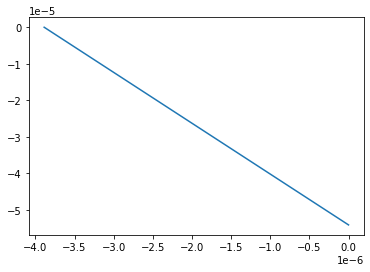

In [12]:
def main():
    
    time = 0.0
    dt=1
    xEst = np.zeros((4, 1)) #assumption of the true value as a reference 
    time_point=100
    xTrue= np.zeros((4, 1))
    #z = observation_model(x_ref) + Add_noise @ np.random.randn(2, 1)
    
    n = 4  # dimension of State Vector [x x_dot y y_dot]'
   
    PEst = np.eye(n) # initial of the covariance matrix
    
    wm, wc, gamma = setup_sgmpoints(n,alpha,beta,kappa)
    
    hxEst = xEst
    hxTrue = xTrue
    hz = np.zeros((2, 1))
    xTrue = np.zeros((4, 1))
    
     
    while time_point >= time:
        dt=1
        time += dt
        xTrue, z = measurement(xTrue)
        xEst, PEst = ukf_estimation(xEst, PEst, z, wm, wc, gamma)
        hxEst = np.hstack((hxEst, xEst))
        hxTrue = np.hstack((hxTrue, xTrue))
        hz = np.hstack((hz, z))
        
        #plt.cla()
        #plt.plot(np.array(hxTrue[0, :]).flatten(),
                    # np.array(hxTrue[1, :]).flatten(), "-b")
        plt.plot(xEst[0,:],xEst[2,:]) 
        
if __name__ == '__main__':
    main()
